## Looking at the data first

Since the vast majority of the HAM10000 dataset consists of images, there is relatively little tabular data to clean and wrangle. However, there is a .csv file containing the ID code for the condition, the ID code of the image, the diagnoses, the age of the patient, the sex of the patient, and the location of the condition, the first ten rows of which are shown below.

In [25]:
#Importing necessary modules.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [48]:
#Loading the dataset
data = pd.read_csv(r'C:\Users\songs\Desktop\CSV files\dataverse_files\HAM10000_metadata.csv')
data.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


According to the website where the data was found, the columns are as follows:
* **lesion_id** - Lesion ID (identification code for the skin condition, may or may not be unique for every picture as multiple pictures may be taken for the same condition
* **image_id** - Image ID (identification code for the image itself, is unique for every picture
* **dx** - Diagnosis
* **dx_type** - How the Diagnosis was made (histology, confocal viewing, at a follow-up, or by consensus)
* **age** - Age of the patient
* **sex** - Sex of the patient
* **localization** - Where the skin condition was found

## Dealing with null values

First, I used the .info() method to at the data types and in each column and to look for any null values. 

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


The file contains 10015 rows, each one corresponding to an image in the dataset, and age is the only numerical column. 

So far, it appears that the only column which contains any null values is the “age” column with 57 nulls. However, it is entirely possible that missing values in other columns were not encoded as “NaN”, and were instead put in as something else. To test whether this was true, I looked at the number of unique values in every categorical column and what the values were.

#### Looking for missing values in categorical variables

In [28]:
data.nunique()

lesion_id        7470
image_id        10015
dx                  7
dx_type             4
age                18
sex                 3
localization       15
dtype: int64

For non-numerical columns with a reasonable number of unique values ("dx", "dx_type", "sex", "localization") I looked at the unique values and the count of each:

In [29]:
data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [30]:
data['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [31]:
data['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [32]:
data['localization'].value_counts()

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

Below are barplots containing the above information for easier viewing.

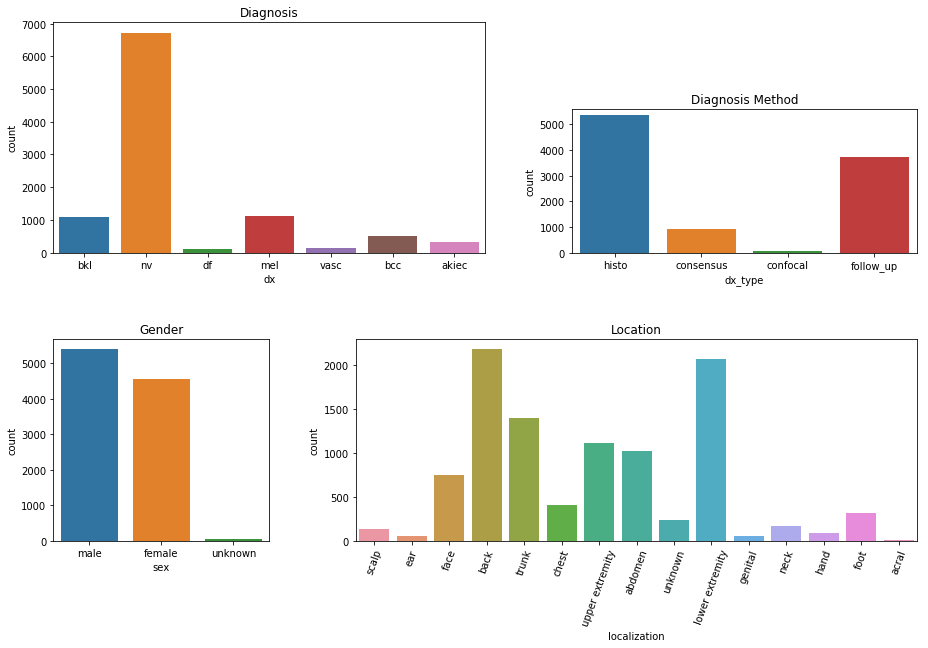

In [33]:
fig = plt.figure()

ax1 = fig.add_axes([0.1, 1.3, 1.0, 0.8])
ax2 = fig.add_axes([1.3, 1.3, 0.8, 0.5])
ax3 = fig.add_axes([0.1, 0.3, 0.5, 0.7])
ax4 = fig.add_axes([0.8, 0.3, 1.3, 0.7])

sns.countplot(data.dx, ax=ax1)
ax1.set_title('Diagnosis')

sns.countplot(data.dx_type, ax=ax2)
ax2.set_title('Diagnosis Method')

sns.countplot(data.sex, ax=ax3)
ax3.set_title('Gender')

sns.countplot(data.localization, ax=ax4)
ax4.set_title('Location')
plt.xticks(rotation=70)

plt.show()

In both the “localization” and “sex” columns, there is a string “unknown” which probably refers to values not inputted.

#### Looking for missing values in the lesion and image id columns

To look for potential missing values in the image and lesion id columns, I compared each value against a regular expression. It seems that the general format is "HAM_(7 digit code)" and "ISIC_(7 digit code)", for lesion and image ids, respectively, and an input different from this format would be suspicious.

In [34]:
pattern1 = '^HAM_\d{7}$'
pattern2 = 'ISIC_\d{7}$'
selector = (~data.lesion_id.str.contains(pattern1))|(~data.image_id.str.contains(pattern2))
data[selector]

,lesion_id,image_id,dx,dx_type,age,sex,localization


Looks like there were no missing values in those columns.

#### How the missing values could be filled

Since both "sex" and "age" has the same number of values not inputted, I was curious if there were some correlation so I looked at columns where both are missing and columns where either one is missing to see if there are any patterns.

In [50]:
data = data.replace('unknown',np.nan)

In [51]:
age_and_sex_unknown = data[(data.sex.isnull()) & (data.age.isnull())]
print(age_and_sex_unknown.shape)
age_and_sex_unknown

(47, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
968,HAM_0001186,ISIC_0033391,bkl,consensus,NaN,NaN,NaN
969,HAM_0002660,ISIC_0033750,bkl,consensus,NaN,NaN,NaN
970,HAM_0000372,ISIC_0033685,bkl,consensus,NaN,NaN,NaN
971,HAM_0000948,ISIC_0033631,bkl,consensus,NaN,NaN,NaN
972,HAM_0000983,ISIC_0033490,bkl,consensus,NaN,NaN,NaN
973,HAM_0007281,ISIC_0034283,bkl,consensus,NaN,NaN,NaN
974,HAM_0001561,ISIC_0032740,bkl,consensus,NaN,NaN,NaN
975,HAM_0000825,ISIC_0034186,bkl,consensus,NaN,NaN,NaN
977,HAM_0006074,ISIC_0034252,bkl,consensus,NaN,NaN,NaN
978,HAM_0006074,ISIC_0033829,bkl,consensus,NaN,NaN,NaN


In [53]:
age_missing = data[(data.sex.notnull()) & (data.age.isnull())]
print(age_missing.shape)
age_missing

(10, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
1886,HAM_0000169,ISIC_0032960,mel,histo,NaN,male,face
1887,HAM_0000169,ISIC_0033708,mel,histo,NaN,male,face
7558,HAM_0007278,ISIC_0025009,nv,histo,NaN,female,chest
7961,HAM_0002417,ISIC_0033442,nv,histo,NaN,male,upper extremity
7962,HAM_0002417,ISIC_0032943,nv,histo,NaN,male,upper extremity
8410,HAM_0006706,ISIC_0031725,nv,histo,NaN,female,abdomen
8411,HAM_0004924,ISIC_0027040,nv,histo,NaN,female,trunk
8555,HAM_0007278,ISIC_0032300,nv,histo,NaN,female,chest
9386,HAM_0000698,ISIC_0031668,nv,consensus,NaN,male,foot
9387,HAM_0000698,ISIC_0027431,nv,consensus,NaN,male,foot


In [54]:
sex_unknown = data[(data.sex.isnull()) & (data.age.notnull())]
print(sex_unknown.shape)
sex_unknown

(10, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
7315,HAM_0005942,ISIC_0032679,nv,histo,60.0,NaN,foot
7316,HAM_0005942,ISIC_0032529,nv,histo,60.0,NaN,foot
7317,HAM_0005942,ISIC_0033119,nv,histo,60.0,NaN,foot
7413,HAM_0003352,ISIC_0032599,nv,histo,35.0,NaN,trunk
7414,HAM_0003352,ISIC_0033472,nv,histo,35.0,NaN,trunk
7415,HAM_0003352,ISIC_0032667,nv,histo,35.0,NaN,trunk
8016,HAM_0004076,ISIC_0032966,nv,histo,0.0,NaN,back
8017,HAM_0004076,ISIC_0033864,nv,histo,0.0,NaN,back
8023,HAM_0003649,ISIC_0032946,nv,histo,45.0,NaN,abdomen
8024,HAM_0003649,ISIC_0033153,nv,histo,45.0,NaN,abdomen


For the 47 rows in which both the age and the sex and not inputted, the localization is not inputted and the diagnosis method is "concensus" for all of them. This means that there is not a lot of information for prediction and may have to be dropped. For the others in which one or the other is missing, there is only one missing value so maybe some prediction could be done.

In [38]:
loc_unknown = data[(data.localization == 'unknown')]
loc_unknown.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
50,HAM_0003670,ISIC_0030105,bkl,histo,80.0,female,unknown
56,HAM_0003569,ISIC_0027960,bkl,histo,75.0,male,unknown
57,HAM_0003569,ISIC_0026955,bkl,histo,75.0,male,unknown
140,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown
461,HAM_0005527,ISIC_0031819,bkl,histo,50.0,male,unknown
511,HAM_0001809,ISIC_0029897,bkl,histo,80.0,female,unknown
535,HAM_0007603,ISIC_0029139,bkl,histo,60.0,male,unknown
821,HAM_0007590,ISIC_0031528,bkl,confocal,40.0,male,unknown
822,HAM_0007590,ISIC_0028615,bkl,confocal,40.0,male,unknown
967,HAM_0006238,ISIC_0034151,bkl,consensus,60.0,male,unknown


## Filling in blank values

I attempted to fill in the null numerical and categorical variables using Random Forest Regressor and Random Forest Classifier, respectively. I chose random forest because it 
* has a high accuracy for for large datasets (unlike DecisionTree or kNN)/
* captures relationships between variables (unlike Naive Bayes).
* doesn't have a lot of parameters to tune (unlike SVM).

### Age

In [57]:
#Generating target and feature tables using data with not null ages.
y = data[data.age.notnull()].age
X = pd.get_dummies(data[data.age.notnull()].drop(['age','lesion_id','image_id'],axis=1))

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In GridSearchCV I tuned the "n_estimators" parameter.

I used mean absolute error for the scoring because I think it's more interpretable compared to mean squared value or root of mean squared value. For example, if the mean absolute error is 10, then that means that on average, the predictions are 10 years off from the actual values. 

In [58]:
#Parameter tuning
param_grid = {'n_estimators':np.arange(10,100,5)}
age_fill = RandomForestRegressor()
age_cv = GridSearchCV(age_fill, param_grid, scoring='neg_mean_absolute_error')
age_cv.fit(X_train, y_train)
print(age_cv.best_params_)
print(age_cv.best_score_)

E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 35}
-11.260384117497908


In [60]:
#Fitting and predicting the for train/test datasets.
age_fill = RandomForestRegressor(n_estimators=35)
age_fill.fit(X_train, y_train)
y_pred = age_fill.predict(X_test)

mean_absolute_error(y_test,y_pred)

11.302968925251848

The above results seem pretty good to me, so I filled out the missing columns with this.

In [61]:
#Converting dataframe to onehotencoded form.
X = pd.get_dummies(data.drop(['age','lesion_id','image_id'],axis=1))

#Creating features.
X_null = X.loc[data.age.isnull(), :]

#Filling in values
y_pred = age_fill.predict(X_null)
data.loc[data.age.isnull(), 'age'] = y_pred

### Sex

I basically repeated the same process as above, except with a classifier instead of a regressor.

In [62]:
#Generating target and feature tables using data with not null values.
y = data[data.sex.notnull()].sex
X = pd.get_dummies(data[data.sex.notnull()].drop(['sex','lesion_id','image_id'],axis=1))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [ ]:
#Parameter tuning
param_grid = {'n_estimators':np.arange(10,100,5)}
sex_fill = RandomForestClassifier()
sex_cv = GridSearchCV(sex_fill, param_grid, scoring='accuracy')
sex_cv.fit(X_train, y_train)
print(sex_cv.best_params_)
print(sex_cv.best_score_)

E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
#Fitting and predicting the for train/test datasets.
sex_fill = RandomForestClassifier(n_estimators=75)
sex_fill.fit(X_train, y_train)
y_pred = sex_fill.predict(X_test)

accuracy_score(y_test,y_pred)

In [ ]:
#Filling in values
X = pd.get_dummies(data.drop(['sex','lesion_id','image_id'],axis=1))
X_null = X.loc[data.sex.isnull(), :]
y_pred = sex_fill.predict(X_null)

data.loc[data.sex.isnull(), 'sex'] = y_pred

### Location of Lesion

In [ ]:
#Generating target and feature tables using data with not null values.
y = data[data.localization.notnull()].localization
X = pd.get_dummies(data[data.localization.notnull()].drop(['localization','lesion_id','image_id'],axis=1))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [ ]:
#Parameter tuning
param_grid = {'n_estimators':np.arange(100,135,5)}
localization_fill = RandomForestClassifier()
localization_cv = GridSearchCV(localization_fill, param_grid, scoring='accuracy')
localization_cv.fit(X_train, y_train)
print(localization_cv.best_params_)
print(localization_cv.best_score_)

In [ ]:
#Fitting and predicting the for train/test datasets.
localization_fill = RandomForestClassifier(n_estimators=130)
localization_fill.fit(X_train, y_train)
y_pred = localization_fill.predict(X_test)

accuracy_score(y_test,y_pred)

In [ ]:
#Filling in values
X = pd.get_dummies(data.drop(['localization','lesion_id','image_id'],axis=1))
X_null = X.loc[data.localization.isnull(), :]
y_pred = localization_fill.predict(X_null)

data.loc[data.localization.isnull(), 'localization'] = y_pred

## Outliers

To look for potential outliers in the only numerical column (age), I made a box-and-whiskers plot of the column.

In [ ]:
data.boxplot(column='age')
plt.title('Boxplot of ages in the HAM10000 Dataset')
plt.ylabel('Age')
plt.show()

As could be seen from the boxplot, there is one outlier at age 0. 

In [ ]:
data[data.age == 0].shape

In [ ]:
data[data.age == 0]

There are 39 values where the patient age is 0, and the diagnoses are either "nv" (nevi, or a mole/birthmark), "vasc" (vascular lesion, or a bruise), or "bkl" (benign keratosis-like lesions), none of which are cancerous. This information could be useful, and doesn't need to be dropped.

## Saving to csv

In [ ]:
data.to_csv(r'C:\Users\songs\Desktop\CSV files\dataverse_files\HAM10000_metadata.csv')